[248 335 110]
[270 354 110]
All images: ['image_1', 'image_2']
All contours: ['contour_outer', 'contour_trab', 'contour_cort']
All data: ['image_1', 'image_2', 'contour_outer', 'contour_trab', 'contour_cort']
Image with associated contours: {'image': 'image_1', 'contours': ['contour_outer', 'contour_trab']}


In [30]:
for key in processor.get_all_images():
    print(processor.data[key].shape)

(270, 354, 110)
(270, 354, 110)


In [1]:
import numpy as np
import pandas as pd
from functools import reduce
from ifb_framework.IO_modules import aim
from ifb_framework.timelapsed_remodelling.transform import TimelapsedTransformation
from ifb_framework.timelapsed_remodelling.register import Registration
from ifb_framework.timelapsed_remodelling.contour import outer_contour, inner_contour, combined_threshold, getLargestCC
from ifb_framework.timelapsed_remodelling.remodell import hrpqct_remodelling_logic
from ifb_framework.timelapsed_remodelling.reposition import pad_and_align_images, boundingbox_from_mask, update_pos_with_bb, pad_array_to_max_shape_centered
from ifb_framework.timelapsed_remodelling.visualise import dict_to_vtkFile
import os
class Timelapse:
    def __init__(self, site, name, threshold=225, cluster=5):
        """
        Initialize the Timelapse object.

        Parameters:
            site (str): The site of the timelapse.
            name (str): The name of the timelapse.
            threshold (int): Threshold value for image processing (default: 225).
            cluster (int): Cluster value for image processing (default: 5).
        """
        self.image_series = {}
        self.image_positions = {}
        self.image_series_name = {}
        self.contour_series = {}
        self.contour_series_path = {}
        self.contour_names = {}
        self.image_shapes = []
        self.transform = TimelapsedTransformation()
        self.registration = None
        self.analysis_results = []
        self.analysis_data = {}
        self.site = site
        self.sample_name = name
        self.threshold = threshold
        self.cluster = cluster

    def _shape(self):
        """
        Get the maximum shape among all images in the timelapse.

        Returns:
            numpy.ndarray: The maximum shape among all images.
        """
        return np.amax(self.image_shapes, axis=0)

    def load(self, path):
        """
        Load an image from the given file path.

        Parameters:
            path (str): The file path of the image.

        Returns:
            numpy.ndarray: The loaded image.
            numpy.ndarray: The position data associated with the image.
        """
        data = aim.load_aim(path)
        image = np.asarray(data.data)
        position = data.position

        return image, position

    def update_image_size(self):
        """
        Update all images in the timelapse to the maximum shape among them.
        """
        sorted_timepoints = sorted(self.image_series.items())
        sorted_timepoints = [timepoint for timepoint, image in sorted_timepoints]
        for t in sorted_timepoints:
            self.image_series[t], self.image_positions[t] = pad_array_to_max_shape_centered(
                self.image_series[t], self.image_positions[t], self._shape())

    def add_image(self, image, timepoint, crop=False):
        """
        Add an image to the timelapse.

        Parameters:
            image (str): The file path of the image to be added.
            timepoint (int): The timepoint of the image.
            crop (bool): Whether to crop the image to the smallest bounding box (default: False).
        """
        self.image_series_name[timepoint] = image

        image, position = self.load(image)

        if crop:
            # Crop image to smallest bounding box
            bb = boundingbox_from_mask(getLargestCC(combined_threshold(image)))
            image = image[bb]
            position = update_pos_with_bb(position, bb)

        # Save the image to the series including the shape and position
        self.image_shapes.append(image.shape)
        self.image_series[timepoint] = image
        self.image_positions[timepoint] = position

        # Initialize contour series for image
        self.contour_series[timepoint] = []
        self.contour_names[timepoint] = []

        # Update image sizes to maximum size
        self.update_image_size()

    def add_contour(self, timepoint, name=None, contour_path=None):
        """
        Add a contour to the specified timepoint of the timelapse.

        Parameters:
            timepoint (int): The timepoint of the contour.
            name (str): The name of the contour (optional).
            contour_path (str): The file path of the contour to be added (optional).
        """
        if contour_path is None:
            # This generates the default trab/cort masks
            print('Generating default contours')
            outer_mask = outer_contour(self.image_series[timepoint], verbose=False)
            trab_mask, cort_mask = inner_contour(
                self.image_series[timepoint], outer_mask, site=self.site, verbose=False)
            self.contour_series[timepoint] += [outer_mask, trab_mask, cort_mask]
            self.contour_names[timepoint] += ['outer', 'trab', 'cort']
        else:
            # This adds custom contours, the first contour will be used for registration
            if name is None:
                self.contour_names[timepoint].append(str(timepoint))
            else:
                self.contour_names[timepoint].append(name)

            contour, position = self.load(contour_path)
            [contour, self.image_series[timepoint]], [position, new_position] = pad_and_align_images(
                [contour > 0, self.image_series[timepoint]], [position, self.image_positions[timepoint]])

            if new_position != self.image_positions[timepoint]:
                print('Warning: Masks seem to be larger than image')

            self.contour_series[timepoint].append(contour)

    def register(self, registration, mask_nr=0):
        """
        Register images in the timelapse using the provided registration method.

        Parameters:
            registration: The registration object to use for image registration.
            mask_nr (int): The index of the contour mask to use for registration (default: 0).
        """
        self.registration = registration

        # Sort the images by timepoints
        sorted_timepoints = sorted(self.image_series.items())

        # Convert the sorted dictionary items to a list
        sorted_timepoints = [(timepoint, image) for timepoint, image in sorted_timepoints]

        for (baseline_t, baseline_im), (followup_t, followup_im) in zip(
                sorted_timepoints[1:], sorted_timepoints[:-1]):
            print('Registering: {} to {}'.format(baseline_t, followup_t))
            registration.setRegistrationParamaters(baseline_im, followup_im)

            # Check if registration masks were set
            if (len(self.contour_series[baseline_t]) > 0) & (len(self.contour_series[followup_t]) > 0):
                registration.setRegistrationMask(
                    self.contour_series[baseline_t][mask_nr],
                    self.contour_series[followup_t][mask_nr])

            registration.execute()
            transform = registration.get_transform()
            metric = registration.reg.GetMetricValue()
            self.transform.add_transform(transform, baseline_t, followup_t, metric)

    def analyse(self, baseline_t, followup_t):
        """
        Analyze the registered images for remodelling.

        Parameters:
            baseline_t (int): The timepoint of the baseline image.
            followup_t (int): The timepoint of the follow-up image.
        """
        # get baseline and transformed followup
        baseline = self.image_series[baseline_t]
        followup = self.transform.transform(self.image_series[followup_t], baseline_t, followup_t)

        # get baseline masks and transformed followup
        baseline_masks = self.contour_series[baseline_t]
        followup_masks = [self.transform.transform(
            m, baseline_t, followup_t) for m in self.contour_series[followup_t]]

        if len(baseline_masks) != len(followup_masks):
            print('Warning unequal baseline ({}) and followup masks ({})'.format(
                len(baseline_masks), len(followup_masks)))

        combined_bmask = np.sum(baseline_masks, axis=0) > 0
        combined_fmask = np.sum(followup_masks, axis=0) > 0

        remodelling_image = hrpqct_remodelling_logic(baseline, followup, mask=combined_bmask & combined_fmask)

        cols = ['image', 'site', 'baseline', 'followup', 'threshold', 'cluster']
        row = [self.sample_name, self.site, baseline_t, followup_t, self.threshold, self.cluster]

        for i, (bmask, fmask, name) in enumerate(zip(baseline_masks, followup_masks, self.contour_names[baseline_t])):
            cols.append('FVBV_{}'.format(name))
            cols.append('RVBV_{}'.format(name))
            cols.append('BV_{}'.format(name))

            row.append(np.sum(remodelling_image[(bmask > 0) & (fmask > 0)] == 3) / np.sum(
                remodelling_image[(bmask > 0) & (fmask > 0)] == 2))
            row.append(np.sum(remodelling_image[(bmask > 0) & (fmask > 0)] == 1) / np.sum(
                remodelling_image[(bmask > 0) & (fmask > 0)] == 2))
            row.append(np.sum(remodelling_image[(bmask > 0) & (fmask > 0)] == 2))

        df = pd.DataFrame([row], columns=cols)
        self.analysis_results.append(df)
        self.analysis_data[(baseline_t, followup_t)] = remodelling_image

    def save_timelapse(self, timedomain, path):
        """
        Save the analyzed timelapse data to a CSV file.

        Parameters:
            path (str): The file path to save the CSV file.
        """
        # We save a dictionary 
        df = pd.concat(self.analysis_results, ignore_index=True)
        print(df)
        df.to_csv(path, index=False)

        # We save the visualisaiton
        for t in [timepoint for timepoint, image in sorted(self.image_series.items())]:
        
            if t!=timedomain:
                image = self.transform.transform(self.image_series[t], timedomain, t)
                segmentations = [self.transform.transform(c, timedomain, t) for c in self.contour_series[t]]
            else: #no transform needed 
                image = self.image_series[t]
                segmentations = self.contour_series[t]
            
            seg_names = self.contour_names[t]
            contour_dict = {name: contour for name, contour in zip(seg_names, segmentations)}
            contour_dict['density'] = image
            
            output_directory = path#os.path.join(path,'image_and_segmentations_xx_{}.vti'.format(t))
            dict_to_vtkFile(contour_dict, path+'.vti')

        for im in [image for timepoint, image in sorted(self.analysis_data.items())]:
            dict_to_vtkFile({'remodelling_image':im}, path+'_REM.vti')

# Register images
path_in = '/Users/matthiaswalle/Documents/Cross_Calib/'
path_out = 
patient = 'XCALIB_0003_RL_M??_XT1*'

#def process_patient(p)
reg = Registration(
    sampling = 0.01,
    num_of_iterations = 100, 
) 

reg.setOptimizer('powell')

reg.setMultiResolution(
    shrinkFactors=[12, 8, 4, 2, 1, 1], 
    smoothingSigmas=[0, 0, 0, 0, 1, 0])

reg.setInterpolator('linear')
reg.setSimilarityMetric('correlation')

tl = Timelapse('radius',name=patient)
tl.add_image('/XCALIB_0003_RL_M06_XT1.AIM;1', 1)
tl.add_image('/Users/matthiaswalle/Documents/Cross_Calib/XCALIB_0003_RL_M12_XT1.AIM;1', 2)
tl.add_contour(1)
tl.add_contour(2)
tl.add_contour(1,contour_path='/Users/matthiaswalle/Documents/Cross_Calib/XCALIB_0003_RL_M06_XT1_CORTEX.AIM;1',name='CORTEX')
tl.add_contour(2,contour_path='/Users/matthiaswalle/Documents/Cross_Calib/XCALIB_0003_RL_M12_XT1_CORTEX.AIM;1',name='CORTEX')
tl.register(reg)
tl.analyse(1,2)
tl.analyse(1,2)
tl.save_timelapse(1,'/Users/matthiaswalle/Documents/vtkworking')




[ WARNING ] - /Users/matthiaswalle/Documents/GitHub/framework/ifb_framework/IO_modules/aim.py:63: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  self.data = Quantity(np.asarray(data), Quantity(data).units)

[ WARNING ] - /var/folders/_8/q2pszsk95tdcdjvdcqpmwsz40000gn/T/ipykernel_10246/3597082782.py:60: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  image = np.asarray(data.data)

Generating default contours
Finished Outer Contour: 6.5140 seconds
Finished Inner Contour: 7.7011 seconds
Generating default contours
Finished Outer Contour: 6.4501 seconds
Finished Inner Contour: 7.0372 seconds
[ WARNING ] - /Users/matthiaswalle/miniconda3/envs/my_x86_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do t

In [3]:
import vtk
def plot_vtk_file(file_path):
    # Step 1: Read the VTK file using vtkPolyDataReader
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(file_path)
    reader.Update()

    # Step 2: Retrieve the data from the reader
    data = reader.GetOutput()

    # Step 3: Create a mapper to map the data to graphics primitives
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputData(data)

    # Step 4: Create an actor to represent the mapper in the scene
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    # Step 5: Create a renderer to display the actor
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)

    # Step 6: Create a render window to hold the renderer
    render_window = vtk.vtkRenderWindow()
    render_window.AddRenderer(renderer)

    # Step 7: Create an interactor to enable user interactions
    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(render_window)

    # Step 8: Start the rendering process
    render_window.Render()
    interactor.Start()

plot_vtk_file('/Users/matthiaswalle/Documents/vtkworking.vti')

2023-07-27 10:42:29.653 (46227.074s) [          889F9E]      vtkDataReader.cxx:567    ERR| vtkPolyDataReader (0x7fe88aff17a0): Unrecognized file type: <?xml version="1.0"?> for file: /Users/matthiaswalle/Documents/vtkworking.vti


In [15]:
import vedo

# Read the VTI file using VTK
import vtk
from vedo import *

file_path = 

# Read the VTI file using VTK
reader = vtk.vtkXMLImageDataReader()
reader.SetFileName(file_path)
reader.Update()

# Determine the dataset index you want to visualize (replace 0 with the desired index)
dataset_index = 1

vtk_image_data = reader.GetOutput()
vtk_image_data.GetPointData().SetActiveScalars(reader.GetPointArrayName(dataset_index))

# Convert VTK image data to vedo Volume
vol = vedo.Volume(vtk_image_data)

plt = Plotter(shape=[1,2],axes=True,sharecam=True)
plt.at(0).show()
#plt.at(1).show()
plt.at(0).add(vol)
# Show the volume using an interactive window
#vedo.show(vol, axes=0, bg='white',viewup="z")
plt.show()


ModuleNotFoundError: No module named 'vtkbone'

/var/folders/_8/q2pszsk95tdcdjvdcqpmwsz40000gn/T/ipykernel_35930/2535098192.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', lut=256)  # Get the Reds colormap with 256 colors


AttributeError: 'Axes' object has no attribute 'flatten'

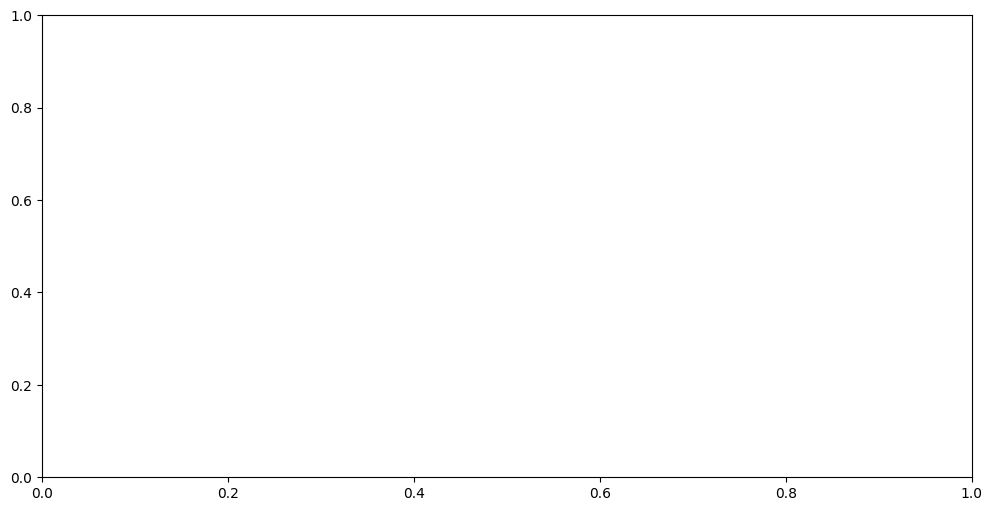

In [42]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# load the data
filename = '/Users/matthiaswalle/Documents/vtkworking.vti'

# load the data
grid = pv.read(filename)
datasets = grid.array_names
num = len(grid.array_names)

# Create a custom colormap with transparency for background (0 value) and red for foreground (1 value)
cmap = plt.cm.get_cmap('Reds', lut=256)  # Get the Reds colormap with 256 colors
cmap = ListedColormap(cmap(np.linspace(0, 1, 256)))
cmap.set_under(alpha=0)  # Set alpha value for values < 0 (background) to 0 for transparency

# Create subplots using Matplotlib
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

def plot_contour(filename):
    
for i in range(num):
    # Create a separate plotter for each dataset
    p = pv.Plotter(off_screen=True)
    p.add_text(f"{datasets[i]}", position='upper_left', font_size=12, color="black")
    p.add_mesh(grid, scalars=datasets[i], cmap=cmap, show_scalar_bar=False)  # Use the custom colormap

    # Screenshot the plot and transfer it to Matplotlib subplot
    img = p.screenshot(transparent_background=True)
    axs[i].imshow(img)
    axs[i].axis("off")

# Display the Matplotlib figure
plt.show()


In [17]:
mesh

ImageData (0x7fb201d5f820)
  N Cells:      10350313
  N Points:     10513800
  X Bounds:     0.000e+00, 2.690e+02
  Y Bounds:     0.000e+00, 3.530e+02
  Z Bounds:     0.000e+00, 1.090e+02
  Dimensions:   270, 354, 110
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     5

In [23]:
"""Generate two random sets of points and align
them using the Iterative Closest Point algorithm"""
from random import uniform as u
from vedo import Points, Arrows, Plotter

N1 = 25  # number of points of first set
N2 = 35  # number of points of second set
x = 1.0  # add some randomness

# Create two sets of random points with different colors
pts1 = [(u(0, x), u(0, x), u(0, x) + i) for i in range(N1)]
pts2 = [(u(0, x)+3, u(0, x)+i/3+2, u(0, x)+i+1) for i in range(N2)]
vpts1 = Points(pts1, r=8, c="blue5")
vpts2 = Points(pts2, r=8, c="red5")

# Find best alignment between the 2 sets of Points,
# e.i. find how to move vpts1 to best match vpts2
aligned_pts1 = vpts1.clone().align_to(vpts2, invert=False)

# Create arrows to visualize how the points move during alignment
arrows = Arrows(pts1, aligned_pts1, s=0.7, c='black', alpha=0.2)

# Create a plotter with two subplots
plt = Plotter(N=2, axes=1)
plt.at(0).show(vpts1, vpts2, __doc__)
plt.at(1).show(aligned_pts1, arrows, vpts2, viewup="z")
plt.interactive().close()

In [47]:
arr = TimedNumpyArray(np.ones([3,3,3]),position=(0,0,0))

arr.position

(0, 0, 0)

In [29]:
tl.contour_names

{1: 'CORTEX', 2: 'CORTEX'}

In [40]:
import numpy as np
from ifb_framework.slice_browser import jupyter_browser

# Important: if you are running this locally in Jupyter (rather than JupyterLab)
# a different backend is needed - replace 'ipympl' below with 'notebook'
%matplotlib ipympl

my_data = {'images':tl.analysis_data[(1, 2)],'baseline':tl.contour_series[1][2],'followup':tl.image_series[2]}

jupyter_browser(my_data)
remodelling_image.shape

GridBox(children=(Box(children=(Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'hom…

(270, 354, 110)

In [4]:
from ifb_framework.timelapsed_remodelling.resize_reposition_image import mask_image_crop_series
from ifb_framework.IO_modules import aim

b = aim.load_aim('/Users/matthiaswalle/Documents/Cross_Calib/XCALIB_0003_RL_M06_XT1.AIM;1')
bm = aim.load_aim('/Users/matthiaswalle/Documents/Cross_Calib/XCALIB_0003_RL_M06_XT1_CORTEX.AIM;1')

f = aim.load_aim('/Users/matthiaswalle/Documents/Cross_Calib/XCALIB_0003_RL_M12_XT1.AIM;1')
fm = aim.load_aim('/Users/matthiaswalle/Documents/Cross_Calib/XCALIB_0003_RL_M12_XT1_CORTEX.AIM;1')

positions = [b.position, f.position]
images = [b.data,f.data]

masks = [bm.data, fm.data]
masks_pos = [bm.position, fm.position]
images = [b.data,f.data]
images_pos = [b.position, f.position]


masks, images, masks_pos, images_pos = mask_image_crop_series(masks, images, masks_pos, images_pos)



[[714, 395, 3], [745, 357, 3]]
[[711, 392, 0], [741, 354, 0]]
[array([718, 402,   3]), array([758, 370,   3])]
[array([718, 402,   3]), array([758, 370,   3])]


[array([718, 402,   3]), array([758, 370,   3])]
[array([718, 402,   3]), array([758, 370,   3])]


In [34]:
#tl.image_series[2]

array([[[ -49.98023377,    3.24526   ,  -24.59307391, ...,
          -70.81521324, -111.95992059,  -28.62000272],
        [ -46.82872427,  -11.63686819,   50.69298635, ...,
          -34.74793786,  -61.71085246,  -44.02738249],
        [ -65.21252968,  -15.13854541,   60.49768257, ...,
            0.26883436,   -7.78502325, -102.33030823],
        ...,
        [  60.32259871,   77.83098482,   73.80405602, ...,
           -9.53586186,  106.89490576,  -33.17218311],
        [  97.79054498,   79.05657185,   79.75690729, ...,
           12.52470464,   31.25867777, -109.85891426],
        [  85.35959085,   -0.25641722,  -99.52896646, ...,
         -123.1652877 , -118.61310731, -136.82182887]],

       [[  -7.60993939,  -27.91966727, -115.9868494 , ...,
          -86.04750915,    8.14760811,   24.95565877],
        [ -37.19911191,  -33.52235083,  -34.22268627, ...,
         -112.13500445,  -22.8422353 ,  -35.62335716],
        [ -63.46169107,  -47.17889199,   26.00616194, ...,
          -75.

In [10]:
from ifb_framework.timelapsed_remodelling.contour import outer_contour, inner_contour, combined_threshold
from ifb_framework.IO_modules import aim
from ifb_framework.timelapsed_remodelling.register import Registration
from ifb_framework.timelapsed_remodelling.remodell import hrpqct_remodelling_logic


def timelapse(baseline, followup, site):

    # Calculate contours
    baseline_endo = outer_contour(baseline, verbose=False)
    baseline_trab, baseline_cort = inner_contour(baseline, baseline_endo, site=site, verbose=False)
    
    followup_endo = outer_contour(followup, verbose=False)
    followup_trab, followup_cort = inner_contour(followup, followup_endo, site=site, verbose=False)
    
    # Register images
    timelapse = Registration(
        sampling = 0.01,
        num_of_iterations = 100, 
    ) 
    
    timelapse.setOptimizer('powell')
    
    timelapse.setMultiResolution(
        shrinkFactors=[12, 8, 4, 2, 1, 1], 
        smoothingSigmas=[0, 0, 0, 0, 1, 0])
    
    timelapse.setInterpolator('linear')
    timelapse.setSimilarityMetric('correlation')
    timelapse.setRegistrationParamaters(baseline, followup)
    timelapse.setRegistrationMask(baseline_endo, followup_endo)
    
    # Transform Images
    tl_followup = timelapse.execute()
    tl_followup_endo = timelapse.transform(followup_endo.astype(int)).astype(bool)
    tl_followup_trab = timelapse.transform(followup_trab.astype(int)).astype(bool)
    tl_followup_cort = timelapse.transform(followup_cort.astype(int)).astype(bool)
    
    # Calculate remodelling image 
    remodelling_image = hrpqct_remodelling_logic(baseline, tl_followup, mask=baseline_endo&tl_followup_endo)
    
    baseline_data = {
        'image': baseline,
        'endo_mask': baseline_endo,
        'trab_mask': baseline_trab,
        'cort_mask': baseline_cort
    }
    
    followup_data = {
        'image': tl_followup,
        'endo_mask': tl_followup_endo,
        'trab_mask': tl_followup_trab,
        'cort_mask': tl_followup_cort
    }
    
    return remodelling_image, baseline_data, followup_data


# Load images
site='radius'
baseline = aim.load_aim('/Users/matthiaswalle/Documents/Cross_Calib/XCALIB_0003_RL_M06_XT1.AIM;1').data.magnitude
followup = aim.load_aim('/Users/matthiaswalle/Documents/Cross_Calib/XCALIB_0003_RL_M12_XT1.AIM;1').data.magnitude

remodelling_image, baseline_data, followup_data = timelapse(baseline, followup, site)


Finished Outer Contour: 6.4815 seconds
Finished Inner Contour: 7.4893 seconds
Finished Outer Contour: 5.6091 seconds
Finished Inner Contour: 6.6130 seconds
Iteration  0 has a value of   -0.77166 at position: (-0.011452642, -0.019397778, -0.003194626, -0.179801457, -8.623129664, -12.064148126)
Iteration  1 has a value of   -0.84484 at position: (-0.030166962, -0.032967344, 0.014652430, -0.808612133, -6.675596404, -12.961882627)
Iteration  2 has a value of   -0.85914 at position: (-0.016804032, -0.019397778, 0.012565177, -0.679543134, -6.537275653, -12.507291933)
Iteration  3 has a value of   -0.86890 at position: (-0.016804015, -0.019397778, 0.024353430, -0.618764505, -6.609816362, -12.066968245)
Iteration  4 has a value of   -0.87238 at position: (-0.012427918, -0.013570616, 0.020253487, -0.426925619, -6.985849494, -12.282646646)
Iteration  5 has a value of   -0.87825 at position: (-0.015227400, -0.011269422, 0.019300084, -0.430197223, -6.885918739, -12.145812550)
Iteration  6 has a va

In [37]:
import networkx as nx

def get_contours(image,site,verbose=False):
    # Calculate all contours for the images
    outer = outer_contour(image, verbose=verbose)
    trab, cort = inner_contour(image, outer, site=site, verbose=verbose)
    return {'outer':outer,'trab':trab,'cort':cort}



def timelapse(image_series, site, verbose=False):
    # Extract the baseline image and the follow-up images from the image series

    contours = [get_contours(image,site,verbose=verbose) for image in image_series]

    # Configure registration
    timelapse = Registration(
        sampling=0.01,
        num_of_iterations=100)
    timelapse.setOptimizer('powell')
    timelapse.setMultiResolution(
        shrinkFactors=[12, 8, 4, 2, 1, 1],
        smoothingSigmas=[0, 0, 0, 0, 1, 0])
    timelapse.setInterpolator('linear')
    timelapse.setSimilarityMetric('correlation')

    # We get all the transformations and register in subsequent order
    transformations = []
    for baseline, followup in zip(image_series[:-1], image_series[1:]):
        # Register images for the follow-up
        timelapse.setRegistrationParamaters(baseline, followup)
        timelapse.setRegistrationMask(baseline_endo, followup_endo)
        timelapse.execute()
        transformations.append(timelapse.get_transform())


    
    # Loop through each follow-up image in the series
    for followup in followup_series:
        # Calculate contours for the follow-up image
        followup_endo = outer_contour(followup, verbose=False)
        followup_trab, followup_cort = inner_contour(followup, followup_endo, site=site, verbose=False)


        tl_followup_endo = timelapse.transform(followup_endo.astype(int)).astype(bool)
        tl_followup_trab = timelapse.transform(followup_trab.astype(int)).astype(bool)
        tl_followup_cort = timelapse.transform(followup_cort.astype(int)).astype(bool)

        # Store follow-up data in a dictionary
        followup_data = {
            'image': tl_followup,
            'endo_mask': tl_followup_endo,
            'trab_mask': tl_followup_trab,
            'cort_mask': tl_followup_cort
        }

        # Append follow-up data to the series data list
        followup_data_series.append(followup_data)

    # Calculate the combined follow-up endo mask after the loop
    combined_followup_endo_mask = reduce(operator.and_, (data['endo_mask'] for data in followup_data_series), tl_baseline_endo.copy())

    # Create a list to store remodelling images for each combination
    remodelling_images = []

    # Calculate remodelling image for each combination of follow-up endo masks
    for followup_data in followup_data_series:
        remodelling_image_combined = hrpqct_remodelling_logic(baseline, followup_data['image'],
                                                              mask=combined_followup_endo_mask)

        remodelling_images.append(remodelling_image_combined)

    return remodelling_images, [baseline_data,]+followup_data_series

remodelling_images, data_series = timelapse([baseline, followup, followup], site)

Finished Outer Contour: 6.6102 seconds
Finished Inner Contour: 7.5510 seconds
Finished Outer Contour: 5.5965 seconds
Finished Inner Contour: 6.5990 seconds
Iteration  0 has a value of   -0.66745 at position: (0.019156772, 0.132771599, -0.010930649, 0.106051169, -7.198421286, -7.986996353)
Iteration  1 has a value of   -0.70279 at position: (0.013595099, 0.183256112, -0.024997939, 0.527610352, -6.695868381, -6.438561798)
Iteration  2 has a value of   -0.71542 at position: (0.012657953, 0.126228252, -0.018408705, 0.245474388, -6.874745636, -8.197258516)
Iteration  3 has a value of   -0.71697 at position: (0.012652673, 0.127438393, -0.017641098, 0.245650970, -7.004952374, -8.160758457)
Iteration  4 has a value of   -0.71705 at position: (0.012600381, 0.127388976, -0.017296603, 0.272868947, -7.023822942, -8.162180009)
Iteration  5 has a value of   -0.72185 at position: (0.016122747, 0.128553657, -0.016543772, 0.284416694, -6.930731098, -8.441862081)
Iteration  6 has a value of   -0.72903 a

In [22]:
import os
import yaml
import numpy as np
from glob import glob
import networkx as nx
import SimpleITK as sitk
from copy import deepcopy
from skimage.filters import gaussian

class timelapsed_transformation:
    def __init__(self):
        self.data = nx.DiGraph()

    def addTransform(self, transform, source=0, target=0, metric=0):
        # Adding transform
        self.data.add_edge(source, target, transform=transform, finalMetric=metric, label='{}TO{}'.format(source,target))
        # Adding inverse transform
        self.data.add_edge(target,source,transform=transform.GetInverse(),finalMetric=metric,label='{}TO{}'.format(source,target))
        # Adding source eigentransform if not exist
        if self.data.has_edge(source, source) == False:
            self.data.add_edge(source,source,transform=sitk.Euler3DTransform(),finalMetric=1,label='{}TO{}'.format(source,source))
        # Adding target egientransform if not exist
        if self.data.has_edge(target, target) == False:
            self.data.add_edge(target,target,transform=sitk.Euler3DTransform(),finalMetric=1,label='{}TO{}'.format(target,target))
   
    def exists(self, source=0, target=0):
        try:
            # detect shortest path for requested transform
            sp = nx.shortest_path(self.data, source=source, target=target)
            return 1
        except:
            return 0
    
    def getTransform(self, source=0, target=0):

        if self.exists(source, target):
            # Get shortest path as combination of transformaitons
            sp = nx.shortest_path(self.data,source=source,target=target)
            pathGraph = nx.path_graph(sp)  # does not pass edges attributes

            # Extract the edge metrics again
            transformations = [self.data.edges[ea[0], ea[1]]['transform'] for ea in pathGraph.edges()]
            metrics = [self.data.edges[ea[0], ea[1]]['finalMetric'] for ea in pathGraph.edges()]
            labels = [self.data.edges[ea[0], ea[1]]['label'] for ea in pathGraph.edges()]
            print("Shortest transformation path: {} with metrics: {}: ".format(sp, metrics))

            # Making the composite transform
            composite_transform = sitk.CompositeTransform(transformations)
            composite_transform.FlattenTransform()
            
            return composite_transform, metrics, list(sp)

        else:
            # Just return something in case
            print('Warning: Returning empty transformation')
            return sitk.Euler3DTransform()

    def transform(self, image, source, target, interpolator='linear'):

        # Get transformation
        transform = self.getTransform(source=source, target=target)

        # Cast ITK images
        im = sitk.Cast(sitk.GetImageFromArray(stack.astype(int)),sitk.sitkFloat32)

        # Resample Images and get array
        resampled_image = sitk.GetArrayFromImage(sitk.Resample(im,im, transform,strToSitkInterpolator(interpolator),0.0,im.GetPixelID()))
            
        return resampled_image

    def saveTransform(self, path):

        data = nx.to_dict_of_dicts(self.data)
        
        if not os.path.exists(path):
            os.makedirs(path)

        for key1, lvl2 in data.items():
            for key2, lvl3 in lvl2.items():
                if key1<key2:
                    filename = '{}_{}_{}.tfm'.format(
                        key1, key2, os.path.basename(path))
                    transform = data[key1][key2]['transform']
                    transform = self._simplifyCompositeTransform(transform)
                    sitk.WriteTransform(
                        transform, os.path.join(
                            path, filename))
    
                    with open(os.path.join(path, filename.replace('.tfm', '.yml')), 'w') as handle:
                        yaml.dump({'metric': float(
                            data[key1][key2]['finalMetric'])}, handle, default_flow_style=True)


    def loadTransform(self, path):
        print(os.path.join(path,'*{}.tfm'.format(os.path.basename(path))))
        tpaths = glob(os.path.join(path,'*{}.tfm'.format(os.path.basename(path))))

        for tpath in tpaths:
            sitktransform = sitk.CompositeTransform(
                sitk.ReadTransform(tpath))
            with open(tpath.replace('.tfm', '.yml'), "r") as stream:
                metric = yaml.load(
                    stream, Loader=yaml.FullLoader)['metric']
            source, target = os.path.basename(tpath).split('_')[:2]
            print(
                'Adding transform from {} to {} with metric={}'.format(
                    int(source),
                    int(target),
                    format(
                        float(metric),
                        '.4f')))

            self.addTransform(
                sitktransform,
                source=int(source),
                target=int(target),
                metric=float(metric))
   

    def _simplifyCompositeTransform(self, CompositeTransform):
        CompositeTransform = sitk.CompositeTransform(CompositeTransform)
        CompositeTransform.FlattenTransform()
        numOf = CompositeTransform.GetNumberOfTransforms()
        nonEmpty = []
        for n in range(numOf):
            if CompositeTransform.GetNthTransform(n).GetParameters(
            ) != CompositeTransform.GetNthTransform(n).GetInverse().GetParameters():
                nonEmpty.append(CompositeTransform.GetNthTransform(n))

        if len(nonEmpty) > 0:
            CompositeTransform = sitk.CompositeTransform(nonEmpty)
        else:
            CompositeTransform = sitk.CompositeTransform(
                [sitk.Euler3DTransform()])

        CompositeTransform.FlattenTransform()
        return CompositeTransform

T = timelapsed_transformation()
T.addTransform(sitk.Euler3DTransform(), 0, 1, 0.9)
T.addTransform(sitk.Euler3DTransform(), 1, 2, 0.8)
T.addTransform(sitk.Euler3DTransform(), 2, 3, 0.4)
T.saveTransform('/Users/matthiaswalle/Documents/GitHub/remodelling/transform/test')
T.loadTransform('/Users/matthiaswalle/Documents/GitHub/remodelling/transform/test')


/Users/matthiaswalle/Documents/GitHub/remodelling/transform/test/*test.tfm
Adding transform from 2 to 3 with metric=0.4000
Adding transform from 0 to 1 with metric=0.9000
Adding transform from 1 to 2 with metric=0.8000


/Users/matthiaswalle/Documents/GitHub/remodelling/transform/test/*test.tfm
Adding transform from 2 to 3 with metric=0.4000
Adding transform from 0 to 1 with metric=0.9000
Adding transform from 1 to 2 with metric=0.8000


In [28]:
import numpy as np
from ifb_framework.slice_browser import jupyter_browser

# Important: if you are running this locally in Jupyter (rather than JupyterLab)
# a different backend is needed - replace 'ipympl' below with 'notebook'
%matplotlib ipympl

my_data = {'baseline':baseline, 'tl_followup':tl_followup, 'remodelling_image':remodelling_image[1]}

jupyter_browser(my_data)

GridBox(children=(Box(children=(Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'hom…

In [25]:
#np.sum(remodelling_image[1]==1)/np.sum(remodelling_image[1]==2)
np.sum(remodelling_image[1]==3)/np.sum(remodelling_image[1]==2)

0.02276010967091059

In [26]:
np.sum(remodelling_image[1]==1)/np.sum(remodelling_image[1]==2)

0.02280392545620448

In [21]:
import numpy as np
import time
from scipy import ndimage
from skimage.filters import gaussian


def getLargestCC(segmentation: np.ndarray) -> np.ndarray:
    labels = ndimage.label(segmentation)[0]
    largestCC = labels == np.argmax(np.bincount(labels.flat, weights=segmentation.flat))
    return largestCC  


def outer_contour(density_baseline: np.ndarray, options: dict = None) -> (np.ndarray, float):
    start_time = time.time()

    if options is None:
        opt = {
            'periosteal_threshold': 250,  # mg/cm**3
            'periosteal_kernelsize': 5,
            'gaussian_sigma': 1.5,
            'gaussian_truncate': 1,
            'expansion_depth': [0, 5], #0 5 
            'init_pad': 15,
            'fill_holes': True,
        }
    else:
        opt = options 

    density_baseline = density_baseline.astype('float16')  # Convert to float32 for memory efficiency

    # Thresholds
    periosteal_threshold = opt['periosteal_threshold']

    # Circular kernel size
    periosteal_kernelsize = ball(opt['periosteal_kernelsize']) 

    # Filter parameters
    gaussian_sigma = opt['gaussian_sigma']
    gaussian_truncate = opt['gaussian_truncate']

    # Sections where the density_baseline image is padded around which zeros (black) to get a mask from tightly cropped images
    init_pad_x = opt['init_pad']
    init_pad_y = opt['init_pad']
    depth = opt['expansion_depth'][0]
    density_baseline_padded = np.pad(density_baseline, ((init_pad_x, init_pad_x), (init_pad_y, init_pad_y), (depth, depth)), mode='constant', constant_values=0)

    # Timer for padding
    pad_start_time = time.time()
    density_baseline_padded = np.pad(density_baseline, ((init_pad_x, init_pad_x), (init_pad_y, init_pad_y), (depth, depth)), mode='constant', constant_values=0)
    pad_elapsed_time = time.time() - pad_start_time

    # Gaussian filter
    gaussian_start_time = time.time()
    density_filtered = gaussian(density_baseline_padded, sigma=gaussian_sigma, mode='mirror', truncate=gaussian_truncate)
    gaussian_elapsed_time = time.time() - gaussian_start_time

    # Thresholding
    threshold_start_time = time.time()
    density_thresholded = density_filtered > periosteal_threshold
    threshold_elapsed_time = time.time() - threshold_start_time

    depth = opt['expansion_depth'][1]
    density_thresholded_padded = np.pad(density_thresholded, ((0, 0), (0, 0), (depth, depth)), mode='reflect')

    # Timer for getting the greatest component
    component_start_time = time.time()
    greatest_component = getLargestCC(density_thresholded_padded)
    component_elapsed_time = time.time() - component_start_time

    # Dilatation
    dilate_start_time = time.time()
    density_dilated = ndimage.morphology.binary_dilation(greatest_component, structure=periosteal_kernelsize, iterations=1)
    dilate_elapsed_time = time.time() - dilate_start_time

    # Determine outer region and invert
    outer_region_start_time = time.time()
    outer_region = getLargestCC(density_dilated == 0)
    outer_region = ~outer_region  # Invert the outer region mask
    outer_region_elapsed_time = time.time() - outer_region_start_time

    # Erosion to get the final mask (periosteal)
    erosion_start_time = time.time()
    mask_eroded = ndimage.morphology.binary_erosion(outer_region, structure=periosteal_kernelsize, iterations=1)
    erosion_elapsed_time = time.time() - erosion_start_time

    # Removal of initial padding and added slides, which were introduced against clipping of the erosion
    mask_start_time = time.time()
    mask = mask_eroded[init_pad_x:-init_pad_x, init_pad_y:-init_pad_y, depth:-depth]
    mask_elapsed_time = time.time() - mask_start_time

    # Option to fill any potential holes in the mask
    if opt['fill_holes']:
        fill_holes_start_time = time.time()
        mask = ndimage.binary_fill_holes(np.pad(mask, ((0, 0), (0, 0), (1, 1)), mode='constant', constant_values=1))[:, :, 1:-1]
        fill_holes_elapsed_time = time.time() - fill_holes_start_time
    else:
        fill_holes_elapsed_time = 0.0

    elapsed_time = time.time() - start_time

    print("Elapsed Time: {:.4f} seconds".format(elapsed_time))
    print("Padding Time: {:.4f} seconds".format(pad_elapsed_time))
    print("Gaussian Filter Time: {:.4f} seconds".format(gaussian_elapsed_time))
    print("Thresholding Time: {:.4f} seconds".format(threshold_elapsed_time))
    print("Get Greatest Component Time: {:.4f} seconds".format(component_elapsed_time))
    print("Dilation Time: {:.4f} seconds".format(dilate_elapsed_time))
    print("Outer Region Time: {:.4f} seconds".format(outer_region_elapsed_time))
    print("Erosion Time: {:.4f} seconds".format(erosion_elapsed_time))
    print("Mask Time: {:.4f} seconds".format(mask_elapsed_time))
    print("Fill Holes Time: {:.4f} seconds".format(fill_holes_elapsed_time))

    return mask.astype(bool)


In [17]:
import itertools
from skimage.morphology import ball
import numpy as np
from scipy.ndimage import binary_opening, zoom, binary_closing
from skimage.morphology import ball

import numpy as np

import numpy as np

def crop_pad_image(reference_image, resize_image, ref_img_position=None,
                   resize_img_position=None, delta_position=None, padding_value=0):
    '''
    Parameters are same as original function.
    '''

    if (ref_img_position or resize_img_position) and delta_position:
        raise ValueError('When specifying delta position, no additional position is needed.')
    elif (not ref_img_position or not resize_img_position) and not delta_position:
        raise ValueError('Positions of both images must be specified.')

    # calculate delta_position from the two given positions
    delta_position = delta_position or np.subtract(resize_img_position, ref_img_position)

    delta_position_end = np.subtract(reference_image.shape, delta_position + resize_image.shape)

    # establishing where to pad and where to slice array
    delta_position = np.maximum(0, delta_position)
    delta_position_slice = np.abs(np.minimum(0, delta_position))

    delta_position_end = np.maximum(0, delta_position_end)
    delta_position_slice_end = np.minimum(0, delta_position_end)

    # solve problem when there was no slicing from the end. any number causes slicing (as the index is exclusive)
    delta_position_slice_end = [None if val == 0 else val for val in delta_position_slice_end]
    
    delta_position_slice_tuple = tuple(slice(x, y) for x, y in zip(delta_position_slice, delta_position_slice_end))

    # bring pad width into correct shape for np.pad function
    pad_width = np.column_stack([delta_position, delta_position_end])

    if reference_image.ndim not in (2, 3):
        raise ValueError("Function currently only supports arrays with 2 or 3 dimensions.")

    # pad, slice and ensure contiguous array memory layout
    resized_image = np.pad(resize_image, pad_width, 'constant', constant_values=padding_value)[delta_position_slice_tuple]
    return np.ascontiguousarray(resized_image)

import numpy as np
from scipy.ndimage import binary_closing, binary_opening, zoom

def fast_binary_closing(
    image: np.ndarray, 
    structure: np.ndarray,
    iterations: int = 1,
    output: np.ndarray = None,
    origin: int = -1
) -> np.ndarray:
    # Downscale the image and structuring element by a factor of 2
    downscale_factor = 0.5
    downsampled_image = zoom(image, zoom=downscale_factor, order=0)
    downsampled_structure = zoom(structure, zoom=downscale_factor, order=0).astype(bool)

    # Perform binary closing on the downsampled image
    closed_downsampled = binary_closing(
        downsampled_image,
        structure=downsampled_structure,
        iterations=iterations,
        output=output,
        origin=origin
    )

    # Upscale the result back to the original image size
    upscale_factor = 1.0 / downscale_factor
    closed_upscaled = zoom(closed_downsampled, zoom=upscale_factor, order=0).astype(bool)

    return closed_upscaled

def fast_binary_opening(
    image: np.ndarray, 
    structure: np.ndarray,
    iterations: int = 1
) -> np.ndarray:
    # Downscale the image and structuring element by a factor of 2
    downscale_factor = 0.5
    downsampled_image = zoom(image, zoom=downscale_factor, order=0)
    downsampled_structure = zoom(structure, zoom=downscale_factor, order=0).astype(bool)

    # Perform binary opening on the downsampled image with the same structure and number of iterations
    opened_downsampled = binary_opening(
        downsampled_image,
        structure=downsampled_structure,
        iterations=iterations
    )

    # Upscale the result back to the original image size
    upscale_factor = 1.0 / downscale_factor
    opened_upscaled = zoom(opened_downsampled, zoom=upscale_factor, order=0).astype(bool)

    return opened_upscaled
    
def boundingbox_from_mask(mask, return_type='slice'):

    if not np.prod(mask.shape):
        logger.warning('Computing bounding box of an array with zero elements.')
        if return_type == 'slice':
            return (slice(0, 0),)*mask.ndim
        elif return_type == 'list':
            return ([0, 0],)*mask.ndim

    out = []
    try:
        for ax in itertools.combinations(range(mask.ndim), mask.ndim - 1):
            nonzero = np.any(mask, axis=ax)
            extent = np.where(nonzero)[0][[0, -1]]
            extent[1] += 1  # since slices exclude the last index
            if return_type == 'slice':
                out.append(slice(*extent))
            elif return_type == 'list':
                out.append(extent)
    except IndexError:
        error = 'Mask is empty. cannot compute a bounding box!'
        logger.error(error)
        raise ValueError(error)

    return tuple(reversed(out))

def inner_contour(density_baseline: np.ndarray, outer_contour: np.ndarray, site: str = 'radius', options: dict = None) -> (np.ndarray, float):

    
    if options is None:
        opt = {}
        opt['site'] = None
        opt['endosteal_threshold'] = 500
        opt['endosteal_kernelsize'] = 3
        opt['gaussian_sigma'] =  1.5
        opt['gaussian_truncate'] =  1
        opt['peel'] =  3
        opt['expansion_depth'] = [0, 3, 10, 3]
        opt['ipl_misc1_1_radius'] = 15
        opt['ipl_misc1_0_radius'] = 800
        opt['ipl_misc1_1_tibia'] = 25
        opt['ipl_misc1_0_tibia'] = 200000
        opt['ipl_misc1_1_misc'] = 15
        opt['ipls_misc1_0_misc'] = 800
        opt['init_pad'] = 30
    else:
        opt = options 


    # Determine scanned site and resulting parameters
    if site == 'radius':
        print("Scanned site is Radius")
        ipl_misc1_1 = opt['ipl_misc1_1_radius']        # = 30
        ipl_misc1_0 = opt['ipl_misc1_0_radius']       # [voxels], NOT USED YET, represents ipl_misc1_0 in IPL_UPAT_CALGARY_EVAL_XT2_NOREG.COM 
    elif site == 'tibia':
        print("Scanned site is Tibia")
        ipl_misc1_1 = opt['ipl_misc1_1_tibia']        # = 50
        ipl_misc1_0 = opt['ipl_misc1_0_tibia']    # [voxels], NOT USED YET, represents ipl_misc1_0 in IPL_UPAT_CALGARY_EVAL_XT2_NOREG.COM
    else:
        ipl_misc1_1 = opt['ipl_misc1_1_misc']        # = 30 
        ipl_misc1_0 = opt['ipls_misc1_0_misc']
        print("Site is not known")

    # Parameters
    # Thresholds     
    endosteal_threshold = opt['endosteal_threshold']     
    # Kernel sizes   
    endosteal_kernelsize = ball(opt['endosteal_kernelsize'])   
    # Filter parameter
    gaussian_sigma = opt['gaussian_sigma']
    gaussian_truncate = opt['gaussian_truncate'] 

    mask = outer_contour.astype(bool)
 
    # Sections where the baseline_density image and mask is padded around which zeros (black) to get mask from tighly cropped images 
    padtime = time.time()
    init_pad_x = opt['init_pad']
    init_pad_y = opt['init_pad']
    depth = opt['expansion_depth'][0]
    density_baseline_padded = np.pad(density_baseline, ((init_pad_x, init_pad_x), (init_pad_y, init_pad_y), (depth, depth)), mode='constant', constant_values=0) #mode='reflect'
    mask = np.pad(mask, ((init_pad_x, init_pad_x), (init_pad_y, init_pad_y), (depth, depth)), mode='constant', constant_values=0)
    print('Padding time: {}'.format(time.time() - padtime))
    # Extracting the endosteal surface 
    # Apply Gaussian filter
    
    gaussiantime = time.time()
    endosteal_density = np.copy(density_baseline_padded)   
    endosteal_density_filtered = ndimage.gaussian_filter(endosteal_density, sigma=gaussian_sigma, order=0, mode='mirror', truncate=gaussian_truncate)  #mode='reflect'/'mirror'
    print('Gaussian time: {}'.format(time.time() - gaussiantime))

    peeltime = time.time()
    peel = opt['peel'] 
    mask_peel = np.pad(mask,((0,0),(0,0),(peel,peel)), mode='reflect') 
    mask_peel = ndimage.binary_erosion(mask_peel, iterations=peel)
    mask_peel = mask_peel[:,:,peel:-peel]
    print('Peel time: {}'.format(time.time() - peeltime))

    # Theshold image
    thresholdingtime = time.time()
    endosteal_density_thresholded = endosteal_density_filtered > endosteal_threshold
    endosteal_density_thresholded = np.logical_and(endosteal_density_thresholded, mask_peel) 


    x_time = time.time()
    density_baseline_cropped = density_baseline_padded[boundingbox_from_mask(endosteal_density_thresholded)] 
    print('thresholdingtime time: {}'.format(time.time() - thresholdingtime))

    # Mask cortical bone away. Results in trabecular bone region only (endosteal)
    x_time = time.time()
    endosteal_masked = np.logical_and(np.invert(endosteal_density_thresholded), mask_peel)
    print('endosteal_masked time: {}'.format(time.time() - x_time))

    # Expanding section (against clipping)
    x_time = time.time()
    depth = opt['expansion_depth'][1]
    endosteal_padded = np.pad(endosteal_masked, ((0,0), (0,0), (depth,depth)), mode='reflect')
    print('endosteal_padded time: {}'.format(time.time() - x_time))
    
    # Extract greatest component
    x_time = time.time()
    endosteal_component = getLargestCC(endosteal_padded)
    print('endosteal_component time: {}'.format(time.time() - x_time))
    
    # 1st Erosion-CL-Dilation loop
    x_time = time.time()
    endosteal_eroded = ndimage.binary_erosion(endosteal_component, structure=endosteal_kernelsize, iterations=1)
    print('endosteal_eroded time: {}'.format(time.time() - x_time))
    
    # Dilation
    x_time = time.time()
    endosteal_dilated = ndimage.binary_dilation(endosteal_eroded, structure=endosteal_kernelsize, iterations=1)
    print('endosteal_dilated time: {}'.format(time.time() - x_time))
    
    # Removal of added slides which were introduced against clipping of the erosion
    x_time = time.time()
    endosteal_dilated = endosteal_dilated[:,:,depth:-depth]
    print('endosteal_dilated time: {}'.format(time.time() - x_time))
    
    # Crops the image
    x_time = time.time()
    endosteal_cropped = endosteal_dilated[boundingbox_from_mask(endosteal_density_thresholded)]
    print('endosteal_cropped time: {}'.format(time.time() - x_time))
    
    # Expanding section (against clipping)
    x_time = time.time()
    bound_x = opt['init_pad']
    bound_y = opt['init_pad']
    depth = opt['expansion_depth'][2]
    endosteal_cropped_padded = np.pad(endosteal_cropped, ((bound_x,bound_x),(bound_y,bound_y),(0, 0)), mode='constant', constant_values=0)
    endosteal_cropped_padded = np.pad(endosteal_cropped_padded, ((0, 0),(0, 0),(depth, depth)), mode='reflect')
    print('endosteal_cropped_padded time: {}'.format(time.time() - x_time))
    
    # !! Large close/open sequence to smooth the contour
    x_time = time.time()
    endosteal_closed = fast_binary_closing(endosteal_cropped_padded, structure=ball(10), iterations=1)
    print('endosteal_closed time: {}'.format(time.time() - x_time))
    
    # Put corners back which may have been deleted by opening process
    x_time = time.time()
    endosteal_opened = fast_binary_opening(endosteal_closed, structure=ball(10))
    print('endosteal_opened time: {}'.format(time.time() - x_time))
    
    # Removal of added slides and x- and y- distance which were introduced against clipping of the erosion
    x_time = time.time()
    endosteal_closed = endosteal_closed[bound_x:-bound_x,bound_y:-bound_y,depth:-depth]
    endosteal_opened = endosteal_opened[bound_x:-bound_x,bound_y:-bound_y,depth:-depth]
    print('endosteal_closed time: {}'.format(time.time() - x_time))
    
    # 2nd Erosion-CL-Dilation loop
    x_time = time.time()
    corners = np.subtract(endosteal_closed.astype(int), endosteal_opened.astype(int)).astype(bool) 
    print('corners time: {}'.format(time.time() - x_time))
    
    x_time = time.time()
    depth = opt['expansion_depth'][3]
    corners_padded = np.pad(corners, ((0, 0), (0, 0), (depth, depth)), mode='reflect')
    print('expansion_depth time: {}'.format(time.time() - x_time))
    
    x_time = time.time()
    corn_ero = ndimage.binary_erosion(corners_padded, structure=ball(3), iterations=1)
    corn_cl = ndimage.binary_dilation(corn_ero, structure=ball(3), iterations=1)
    corners = corn_cl[:,:,depth:-depth]

    trab_mask = np.add(corners, endosteal_opened)

    bound_x = opt['init_pad']
    bound_y = opt['init_pad']
    depth = ipl_misc1_1
    trab_mask_padded = np.pad(trab_mask, ((bound_x,bound_x), (bound_y,bound_y), (0, 0)), mode='constant', constant_values=0)
    trab_mask_padded = np.pad(trab_mask_padded, ((0, 0), (0, 0), (depth, depth)), mode='reflect')
    print('corn_ero time: {}'.format(time.time() - x_time))
    
    # Final closing
    x_time = time.time()
    trab_close = fast_binary_closing(trab_mask_padded, structure=ball(ipl_misc1_1), iterations=1)

    trab_mask = trab_close[bound_x:-bound_x,bound_y:-bound_y,depth:-depth]
    print('Final closing time: {}'.format(time.time() - x_time))
    
    # Resize the masks to the initial image (density_baseline)
    x_time = time.time()
    image_bounds = boundingbox_from_mask(endosteal_density_thresholded, 'list')
    empty_image = np.zeros(density_baseline.shape)
    print('image_bounds time: {}'.format(time.time() - x_time))
    
    x_time = time.time()
    resized_trab_mask = crop_pad_image(empty_image, trab_mask, [0,0,0], [image_bounds[0][0]-init_pad_x, image_bounds[1][0]-init_pad_y,0], padding_value=0)
    print('resized_trab_mask time: {}'.format(time.time() - x_time))
    
    resized_cort_mask = outer_contour.astype(bool)
    resized_cort_mask[resized_trab_mask.astype(bool)]=False

    return resized_trab_mask, resized_cort_mask

In [18]:
import numpy as np
from scipy.ndimage import gaussian_filter, binary_erosion, binary_dilation 

def pad_image(image, pad_width):
  return np.pad(image, pad_width, mode='constant', constant_values=0)

def apply_mask(image, mask):
  return image & mask

def add_components(comp1, comp2):
  return comp1 | comp2

def get_corner_components(img1, img2):
  corners = np.bitwise_xor(img1, img2) 
  corners = binary_dilation(corners, ball(3))
  return corners

def extract_endosteal_surface(density, outer_contour, options=None):

    # Set default options
    opt = {
      'site': None,
      'endosteal_threshold': 500,
      'endosteal_kernelsize': 3,
      'gaussian_sigma': 1.5,
      'gaussian_truncate': 1,
      'peel': 3,
      'expansion_depth': [0, 3, 10, 3],
      'ipl_misc1_1_radius': 15,
      'ipl_misc1_0_radius': 800,
      'ipl_misc1_1_tibia': 25,
      'ipl_misc1_0_tibia': 200000, 
      'ipl_misc1_1_misc': 15,
      'ipls_misc1_0_misc': 800,
      'init_pad': 30
    }

    # Override defaults with provided options
    if options is not None:
        opt.update(options)

    # Set site-specific params
    if opt['site'] == 'radius':
        ipl_misc1_1 = 15
    elif opt['site'] == 'tibia':
        ipl_misc1_1 = 25
    else:
        ipl_misc1_1 = 15

    # Pad input images  
    density_padded = pad_image(density, pad_width=opt['init_pad'])
    mask_padded = pad_image(outer_contour, pad_width=opt['init_pad'])

    # Apply gaussian filter
    density_filtered = gaussian_filter(density_padded, sigma=opt['gaussian_sigma'])

    # Threshold to get endosteal surface
    endosteal_surface = density_filtered > opt['endosteal_threshold']

    # Mask away cortical bone
    endosteal_masked = apply_mask(endosteal_surface, mask_padded) 

    # Extract largest component 
    endosteal_cc = getLargestCC(endosteal_masked)

    # Morphological operations to smooth endosteal contour
    endosteal_closed = fast_binary_closing(endosteal_cc, ball(10))
    endosteal_opened = fast_binary_opening(endosteal_closed, ball(10))

    # Get corner components and add back to smoothed contour
    corners = get_corner_components(endosteal_closed, endosteal_opened)
    endosteal_contour = add_components(corners, endosteal_opened)

    # Final closing
    endosteal_contour_closed = fast_binary_closing(endosteal_contour, ball(ipl_misc1_1))

    # Resize endosteal contour to match original density size
    trab_mask = crop_pad_image(empty_image, endosteal_contour_closed, density.shape) 

    # Create cortical mask
    cort_mask = np.where(trab_mask, outer_contour, False)

    return trab_mask, cort_mask

In [22]:
contour = outer_contour(data.data, options=None)
#trab, cort = extract_endosteal_surface(data.data, contour,{'site':'tibia'})


Elapsed Time: 33.4408 seconds
Padding Time: 0.0481 seconds
Gaussian Filter Time: 0.7899 seconds
Thresholding Time: 0.0222 seconds
Get Greatest Component Time: 1.0622 seconds
Dilation Time: 14.3696 seconds
Outer Region Time: 1.1212 seconds
Erosion Time: 13.9182 seconds
Mask Time: 0.0000 seconds
Fill Holes Time: 1.8044 seconds
